In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
sns.set_palette('pastel')

import warnings
warnings.simplefilter("ignore")

In [2]:
test = pd.read_csv('../data/Filtered_test.csv')
train = pd.read_csv('../data/Filtered_train.csv')

In [3]:
train.head()

,trans_date_trans_time,cc_num,category,amt,is_fraud,last_hour_count,last_hour_avg,last_24h_count,last_24h_avg,dist,dist_diff,part_of_day
0,2019-01-01 12:47:15,60416207185,misc_net,7.27,0,1.0,7.27,1.0,7.27,127.606239,0.000000,Afternoon
1,2019-01-02 08:44:57,60416207185,gas_transport,52.94,0,1.0,52.94,2.0,30.10,110.308921,17.297318,Morning
2,2019-01-02 08:47:36,60416207185,gas_transport,82.08,0,2.0,67.51,3.0,47.43,21.787261,88.521660,Morning
3,2019-01-02 12:38:14,60416207185,kids_pets,34.79,0,1.0,34.79,4.0,44.27,87.204215,65.416954,Afternoon
4,2019-01-02 13:10:46,60416207185,home,27.18,0,2.0,30.98,4.0,49.25,74.212965,12.991250,Afternoon


In [4]:
fraud = train[train['is_fraud'] == 1]
non_fraud = train[train['is_fraud'] == 0]

In [5]:
train.describe()

,cc_num,amt,is_fraud,last_hour_count,last_hour_avg,last_24h_count,last_24h_avg,dist,dist_diff
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,5.788652e-03,1.189499e+00,7.029302e+01,4.884108e+00,7.041224e+01,7.611465e+01,3.313524e+01
std,1.308806e+18,1.603160e+02,7.586269e-02,4.617179e-01,1.535998e+02,3.082072e+00,9.635199e+01,2.911693e+01,2.422883e+01
min,6.041621e+10,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.225452e-02,0.000000e+00
25%,1.800429e+14,9.650000e+00,0.000000e+00,1.000000e+00,1.242000e+01,3.000000e+00,3.569000e+01,5.533491e+01,1.343319e+01
50%,3.521417e+15,4.752000e+01,0.000000e+00,1.000000e+00,4.868000e+01,4.000000e+00,5.559000e+01,7.823175e+01,2.849371e+01
75%,4.642255e+15,8.314000e+01,0.000000e+00,1.000000e+00,8.279000e+01,6.000000e+00,8.098000e+01,9.850327e+01,4.838114e+01
max,4.992346e+18,2.894890e+04,1.000000e+00,7.000000e+00,2.894890e+04,3.600000e+01,2.711977e+04,1.521172e+02,1.413540e+02


### above 28k in amt is considered fraud 
### 7 or above in count is considered fraud 
### dist above 140k is is considered fraud

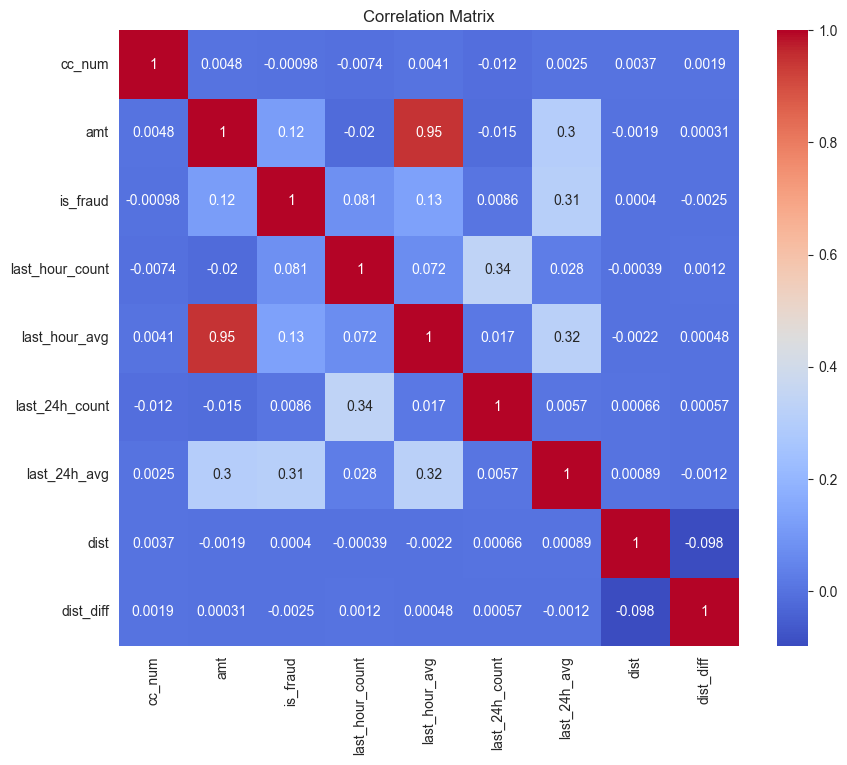

In [19]:
numeric_columns = train.select_dtypes(include=['float64', 'int64', 'int32']).columns
correlation_matrix = train[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [17]:
train.last_hour_avg = np.log1p(train.last_hour_avg)

<Axes: xlabel='last_hour_avg', ylabel='Count'>

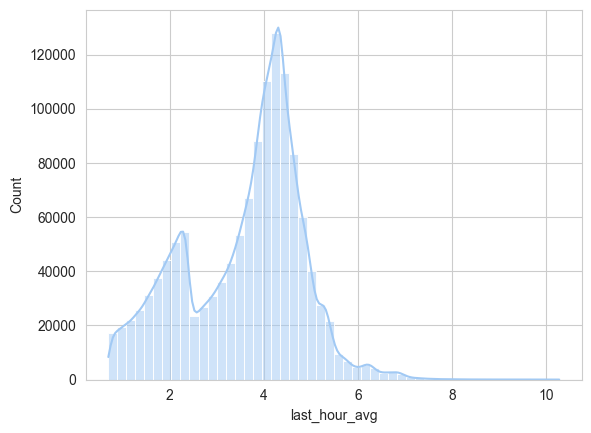

In [18]:
sns.histplot(train['last_hour_avg'], bins=50, kde=True)

<Axes: xlabel='amt', ylabel='Count'>

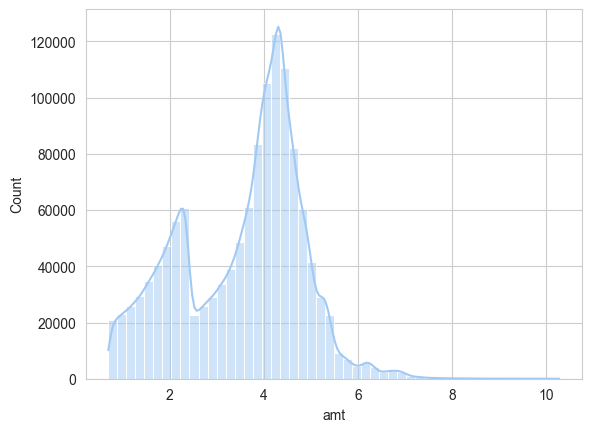

In [13]:
sns.histplot(train['amt'], bins=50, kde=True)

In [11]:
train.amt.skew()
train.amt = np.log1p(train.amt)

In [15]:
train.describe()

,cc_num,amt,is_fraud,last_hour_count,last_hour_avg,last_24h_count,last_24h_avg,dist,dist_diff
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,3.533470e+00,5.788652e-03,1.189499e+00,7.029302e+01,4.884108e+00,7.041224e+01,7.611465e+01,3.313524e+01
std,1.308806e+18,1.289448e+00,7.586269e-02,4.617179e-01,1.535998e+02,3.082072e+00,9.635199e+01,2.911693e+01,2.422883e+01
min,6.041621e+10,6.931472e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.225452e-02,0.000000e+00
25%,1.800429e+14,2.365560e+00,0.000000e+00,1.000000e+00,1.242000e+01,3.000000e+00,3.569000e+01,5.533491e+01,1.343319e+01
50%,3.521417e+15,3.881976e+00,0.000000e+00,1.000000e+00,4.868000e+01,4.000000e+00,5.559000e+01,7.823175e+01,2.849371e+01
75%,4.642255e+15,4.432482e+00,0.000000e+00,1.000000e+00,8.279000e+01,6.000000e+00,8.098000e+01,9.850327e+01,4.838114e+01
max,4.992346e+18,1.027332e+01,1.000000e+00,7.000000e+00,2.894890e+04,3.600000e+01,2.711977e+04,1.521172e+02,1.413540e+02


<Axes: xlabel='amt'>

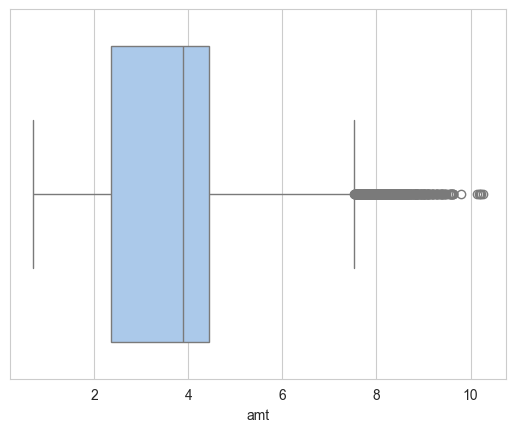

In [12]:
sns.boxplot(x=train['amt'], palette='pastel')

In [7]:
train['last_hour_count'].value_counts()

last_hour_count
1.0    1084162
2.0     183889
3.0      24757
4.0       3270
5.0        495
6.0         86
7.0         16
Name: count, dtype: int64

<Axes: xlabel='last_hour_count', ylabel='is_fraud'>

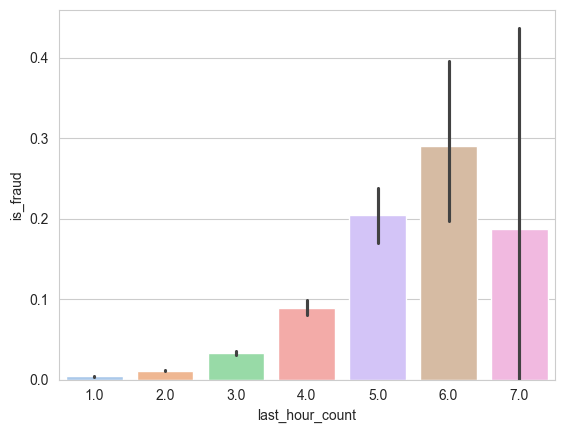

In [9]:
sns.barplot(x='last_hour_count', y='is_fraud', data=train, palette='pastel')

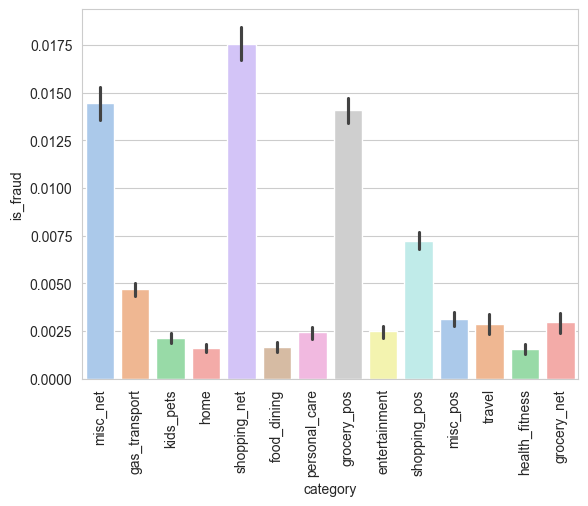

In [10]:
sns.barplot(x='category', y='is_fraud', data=train, palette='pastel')
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='dist_diff', ylabel='Count'>

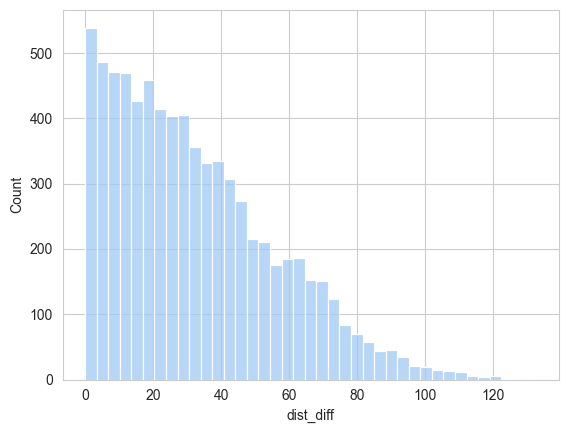

In [22]:
sns.histplot(fraud['dist_diff'], label='Fraud', fill=True, palette='pastel')

<Axes: xlabel='dist_diff', ylabel='Count'>

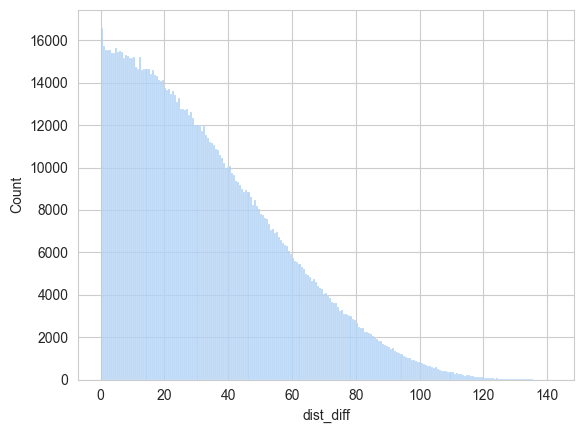

In [23]:
sns.histplot(non_fraud['dist_diff'], label='Fraud', fill=True, palette='pastel')

<Axes: xlabel='amt', ylabel='Count'>

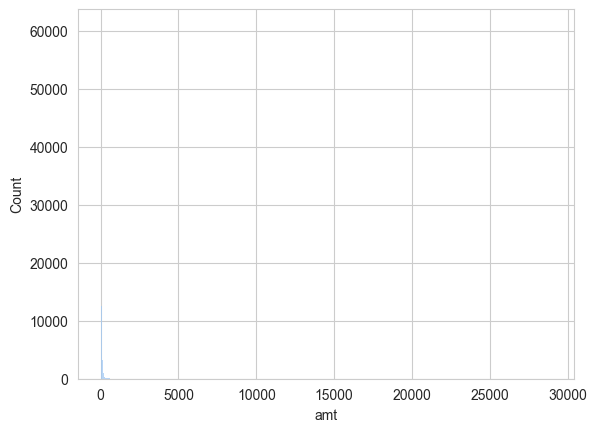

In [24]:
sns.histplot(non_fraud['amt'], label='Fraud', fill=True, palette='pastel')

<Axes: xlabel='last_hour_avg', ylabel='Count'>

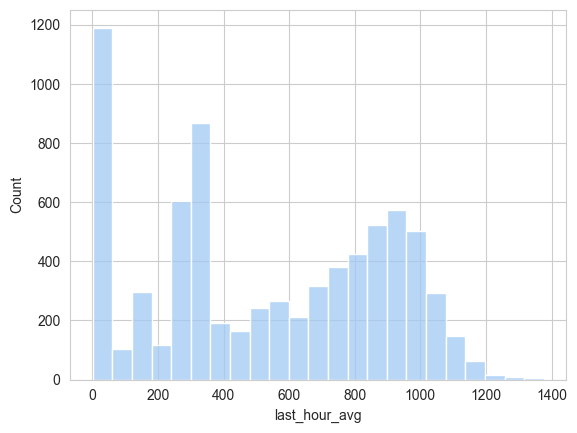

In [25]:
# getting the distribution of last hour average amount corresponding to is fraud column

sns.histplot(fraud['last_hour_avg'], label='Fraud', fill=True, palette='pastel')

# handling new categories 

<Axes: xlabel='last_hour_avg', ylabel='Count'>

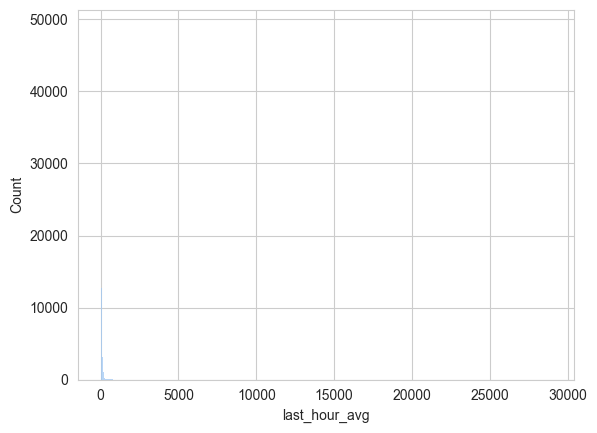

In [26]:
sns.histplot(non_fraud['last_hour_avg'], label='Not Fraud', fill=True, palette='pastel')